# Introduction

This notebook allows you to run a simplified version of the ANTARESS workflow, for the following purpose:
- generating a mock CCF dataset of a transiting planet, as observed with a given spectrograph 

The main interest of the mock datasets is to estimate the detectability of a Rossiter-McLaughlin signature, by analyzing them with the workflow like real observations. 

To use the workflow to its full capabilities, set up a copy of the configuration file `ANTARESS_settings.py` and run `ANTARESS_launcher()` (see README for details). 

In [1]:
import ANTARESS_nbook_bground
input_nbook = ANTARESS_nbook_bground.init('mock')

# System parameters

**Parameters of the host star**

Run this cell to define the host star. 
- `star_name` (string): Name of the star. Should not contain spaces/dashes.
- `Rs` (float): Radius of the star, in $R_\odot$.
- `vsini` (float): Projected stellar surface velocity, in km/s.
- `ld_u1` (float): First coefficient of the quadratic limb-darkening.
- `ld_u2` (float): Second coefficient of the quadratic limb-darkening.

In [2]:
input_nbook['par'].update({
    'star_name' : 'TOI178',
    'Rs'        : 0.651,
    'vsini'     : 1.5,
    'ld_u1'     : 0.787,
    'ld_u2'     : -0.006
})
ANTARESS_nbook_bground.init_star(input_nbook)

**Parameters of transiting planet**

Run this cell to set the transiting planet on which the RM analysis is applied. 
- `planet_name` (string): Name of the transiting planet. Should not contain spaces/dashes.
- `period` (float): Orbital period, in days.
- `T0` (float): Mid-transit time, in ${\rm BJD}_{\rm TBD}$.
- `ecc` (float): Orbital eccentricity.
- `long_per` (float): Longitude of periastron, in degrees. If the orbit is circular, fill in `90.`.
- `Kstar` (float): RV semi-amplitude, in m/s.
- `aRs` (float): Scaled separation $a/R_\star$.
- `incl` (float): Orbital inclination, in degrees.
- `lambda` (float): Sky-projected spin-orbit angle, in degrees.
- `RpRs` (float): Planet-to-star radius ratio $R_{\rm p}/R_\star$.

In [3]:
input_nbook['par'].update({
    'planet_name' : 'TOI178d',
    'period'      : 6.557700,
    'T0'          : 2458747.14623,
    'ecc'         : 0.,
    'long_per'    : 90.,
    'Kstar'       : 0.,
    'aRs'         : 19.57,
    'incl'        : 88.58,
    'lambda'      : 90.,
    'RpRs'        : 0.03623
})

#input_nbook['par'].update({
#    'planet_name' : 'TOI178g',
#    'period'      : 20.70950,
#    'T0'          : 2458748.0302,
#    'ecc'         : 0.,
#    'long_per'    : 90.,
#    'Kstar'       : 0.,
#    'aRs'         : 42.13,
#    'incl'        : 88.823,
#    'lambda'      : 0.,
#    'RpRs'        : 0.0404
#})


ANTARESS_nbook_bground.init_pl(input_nbook,'main')

**Parameters of additional planets in the system**

Run this cell to set additional planets, which will only contribute to the computation of the star Keplerian motion. 

The names and definitions of the parameters are the same as for the main planet (`aRs`, `incl`, `RpRs` are not required).

Copy the cell to add further planets

In [4]:
input_nbook['par'].update({
    'planet_name' : 'Numenor',
    'period'      : 8.,
    'T0'          : 2457176.2,
    'ecc'         : 0.,
    'long_per'    : 90.,
    'Kstar'       : 20.
})
#ANTARESS_nbook_bground.init_pl(input_nbook,'sec')

# Mock dataset properties

**Visit**

Run this cell to define the mock visit. It must overlap with the transit of the `transiting planet`.
- `instrument` (string): Instrument of the visit (e.g. `ESPRESSO`, `NIRPS_HE`...).
- `night` (string): Night of the visit. It is preferred to use the standard format, i.e. `YYYYMMDD`.
- `range` (list): Absolute time range of the visit, in BJD.
- `nexp` (int): Number of exposures in the visit.

In [5]:
input_nbook['par'].update({
    'instrument' : 'ESPRESSO',
    'night'      : 'Test_night',
    'range'      : [2458747.14623 - (0.5*2.346 + 2.05)/24.,2458747.14623 + (0.5*2.346 + 2.05)/24.],      #planet d
    'nexp'       : int( (2.346+4.)*3600./(20.*60.) ),         #Leleu+2021: 20min texp -> 0.93 m/s
#    'range'      : [2458748.0302 - (0.5*2.167 + 2.)/24.,2458748.0302 + (0.5*2.167 + 2.)/24.],      #planet g
#    'nexp'       : int( (2.167+4.)*3600./(20.*60.) ),         #Leleu+2021: 20min texp -> 0.93 m/s    
    
})
ANTARESS_nbook_bground.add_vis(input_nbook,mock=True)

**Radial velocity table**

Run this cell to set the radial velocity table over which CCFs are defined (in km/s, in the star rest frame).
- `x_start` (float): start of the table.
- `x_end` (float): end of the table.
- `dx` (float): step of the table.

In [6]:
input_nbook['par'].update({
    'x_start' : -30.,
    'x_end'   :  30.,
    'dx'      :  0.8
})
ANTARESS_nbook_bground.set_mock_rv(input_nbook)

**Stellar line**

Run this cell to set the absorption line used to tile the star.
- `gamma` (float): systemic rv (in km/s).
- `contrast` (float): intrinsic line constrast.
- `FWHM` (float): intrinsic line full-width at half-maximum (in km/s)
- `flux` (float): disk-integrated line continuum flux (number of counts received for an exposure time of 1 s).
- `noise` (bool): set to True to randomly draw white noise for each CCF pixel, based on its count level (to increase the S/N, increase `flux`). 

Line is arbitrarily set to a Gaussian profile, centered in the star rest frame.

In [7]:
input_nbook['par'].update({
    'gamma'      : 0., 
    'contrast'   : 0.6,   #From a DACE CCF  
    'FWHM'       : 6.5,   #From DACE header, and FWHM_loc = sqrt(6.7**2. - 1.5**2.)
    'flux'       : 5000,  #To ensure error bars on RV of 0.93 m/s in 20min texp  
#    'flux'       : 15000,  #~3 transits
    'noise'      : True,
})
ANTARESS_nbook_bground.set_sysvel(input_nbook,mock=True)
ANTARESS_nbook_bground.set_mock_prof(input_nbook)

# Processing and analysis for plot display.

Run this cell to set up the processing and analysis modules. This has no impact on the generation of the mock dataset, but it is required for its display. 

In [8]:
ANTARESS_nbook_bground.ana_prof(input_nbook,'DI')
ANTARESS_nbook_bground.set_sysvel(input_nbook)
ANTARESS_nbook_bground.align_prof(input_nbook)
ANTARESS_nbook_bground.flux_sc(input_nbook,mock=True)
ANTARESS_nbook_bground.DImast_weight(input_nbook)
ANTARESS_nbook_bground.extract_intr(input_nbook)

Run these cells to set up the plot display of your mock dataset (see at the end of the notebook).

In [9]:
ANTARESS_nbook_bground.plot_system(input_nbook)
ANTARESS_nbook_bground.plot_prop(input_nbook,'DI')

**Disk-integrated CCF series**

Adjust `y_range` to the flux range of the CCFs (vertical axis)

In [10]:
input_nbook['par']['y_range'] = None #[2.8e5,3.55e5] 
ANTARESS_nbook_bground.plot_prof(input_nbook,'DI_prof')

**Intrinsic stellar profiles**

Adjust `y_range` and `v_range` to the flux range of the CCFs (vertical axis in 1D, color scale in 2D)

In [11]:
input_nbook['par']['y_range'] = [0.,2.]
ANTARESS_nbook_bground.plot_prof(input_nbook,'Intr_prof')
input_nbook['par']['v_range'] = [0.2,1.8]
ANTARESS_nbook_bground.plot_map(input_nbook,'Intr_prof')


# Running ANTARESS

Run this cell to launch the ANTARESS workflow. 

The mock CCF profile series can be retrieved under `/ANTARESS/Ongoing/Valinor_Saved_data/Processed_data/instrument_night_i.npz`

In [12]:
%cd ../Method/ 
from ANTARESS_launch.ANTARESS_launcher import ANTARESS_launcher
ANTARESS_launcher(nbook_dic = input_nbook)

/Users/bourrier/Travaux/ANTARESS/Method


/Users/bourrier/opt/anaconda3/lib/python3.8/site-packages/pyfits/__init__.py:21: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  warnings.warn('PyFITS is deprecated, please use astropy.io.fits',


****************************************
Launching ANTARESS
****************************************

Multi-threading: 8 threads available
Running with artificial data
Covariances discounted
Automatic activation of residual profile extraction
Accounting for Keplerian motion from all planets
Automatic definition of T14[TOI178d]=2.35 h
Default nsub_Dpl[TOI178d]=17

-----------------------
Processing instrument : ESPRESSO
-----------------------
  Reading and initializing CCFs
   > Data resampled on a common spectral table
         Calculating data
         Initializing visit Test_night
            Building exposures ... 
           All exposures in Test_night share a common spectral table
   > 19 exposures
  -----------------
  Processing visit: Test_night
  -----------------
   > 19 exposures
         7 in-transit
         12 out-of-transit (6 pre / 6 post)
   > Calculating properties of planet-occulted regions
         Calculating data
   > Analyzing disk-integrated stellar profiles
  

# Plot display

In [13]:
from IPython.display import Image
from IPython.core.display import HTML 

Run the cells below to show saved plots.

**Planetary system architecture**

This plot shows the system along the line-of-sight, to scale. The star is colored as a function of its surface radial velocity field, and the planetary orbit displayed as a green line is controlled by the system values you defined. The black and green arrow are the sky-projected stellar spin and orbital normal. Many more options are available through the plotting configuration file.

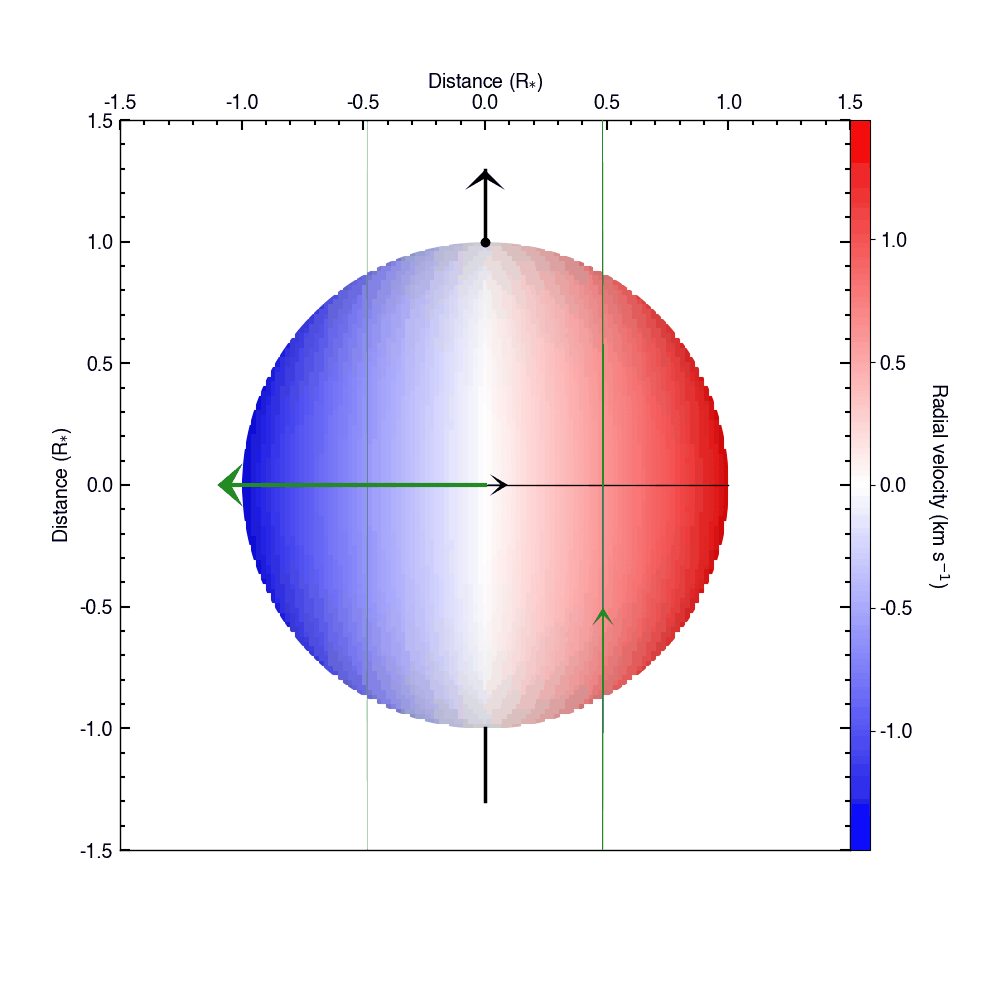

In [14]:
Image(filename = input_nbook['plot_path']+'System_view/System.gif', width=800)

**Disk-integrated CCF series**

This plot shows the series of mock disk-integrated CCFs (blue profiles). Depending on the system properties you defined, you will see by eye the anomalous `bump` induced by the occultation of local stellar lines by the planet.  

The dashed black profiles are best-fit Gaussian models to each CCF, as is usually used to derive RVs.

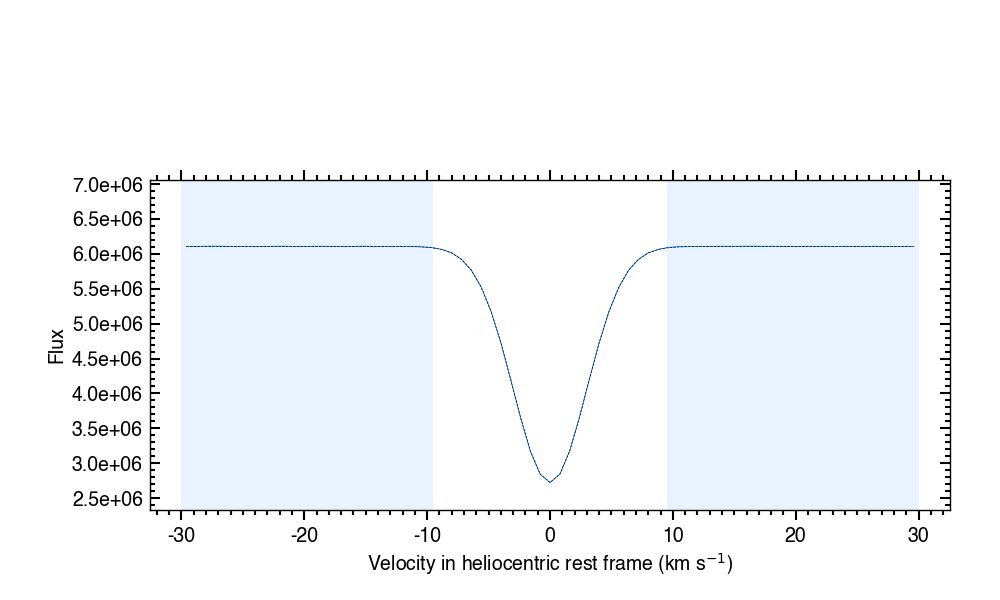

In [15]:
Image(filename = input_nbook['plot_path']+'DI_data/'+input_nbook['par']['instrument']+'_'+input_nbook['par']['night']+'_Indiv/Data/CCF/phase.gif')

**Disk-integrated RV series**

This plot shows the RV series derived from the fits to the mock CCF series. 

Outside of the transit (contacts shown as dashed black lines), RVs trace the Keplerian motion of your mock star with respect to the solar system barycenter (the Keplerian model is plotted as a blue curve).

Inside of the transit, the deviation to the Keplerian curve is the classical RM anomaly induced by the local occultation of stellar lines by the planet. Traditionally, measurements of the sky-projected spin-orbit angle in planetary systems have been performed by analyzing this anomalous signal. With ANTARESS, you will be able to analyze directly the planet-occulted stellar profiles to get a higher precision on the transit chord and orbital architecture of the system.

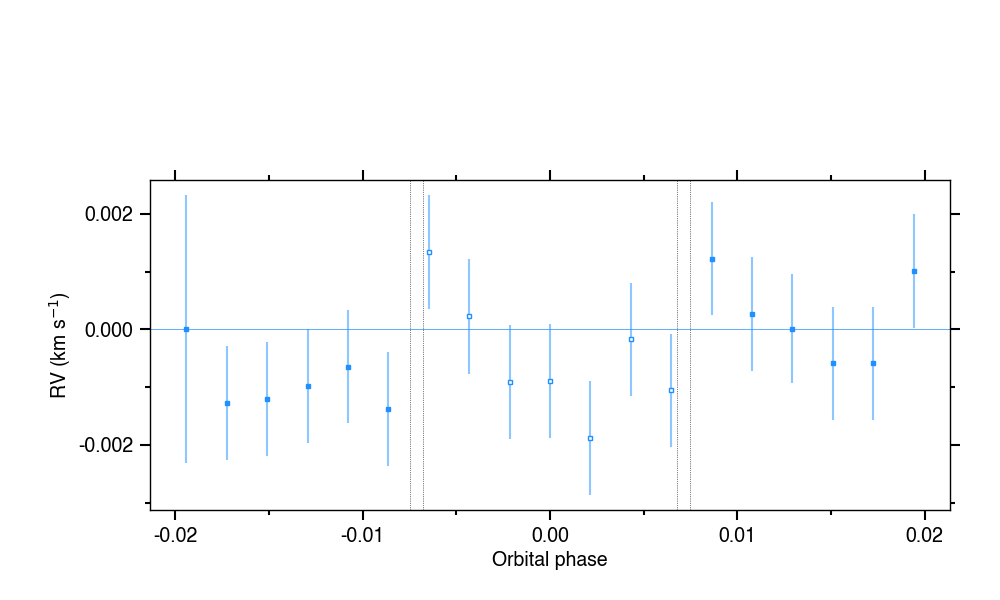

In [16]:
Image(filename = input_nbook['plot_path']+'DI_prop/rv_phase.png')

**Intrinsic CCF series**

These plots show the intrinsic stellar lines from the stellar regions occulted by the planet, as they would be retrieved by applying the workflow to a real dataset. 

The first plot shows the series of mock intrinsic CCFs (blue profiles) in the star rest frame. The second plot shows the series in phase-RV space, colored with flux. CCFs have been normalized to a common flux level unity for visual purpose. The solid green lines trace the centroid of the occulted stellar line, which correspond to the RV of the transited regions. 

This example illustrates how the planet acts as a probe of the stellar surface, allowing us to measure its RV field and center-to-limb variations in the shape of its absorption lines. Note that in the present case the lines you simulated keep a constant shape, and that their effective depth will be smaller than the one you defined because of broadening by the spectrograph and stellar rotation.

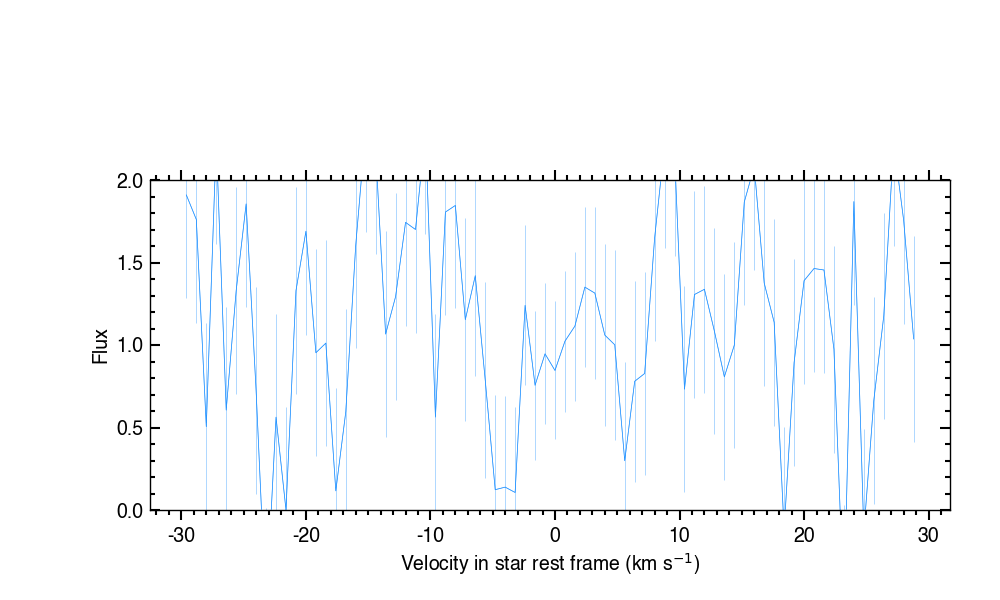

In [17]:
Image(filename = input_nbook['plot_path']+'Intr_data/'+input_nbook['par']['instrument']+'_'+input_nbook['par']['night']+'_Indiv/Data/CCF/phase.gif')

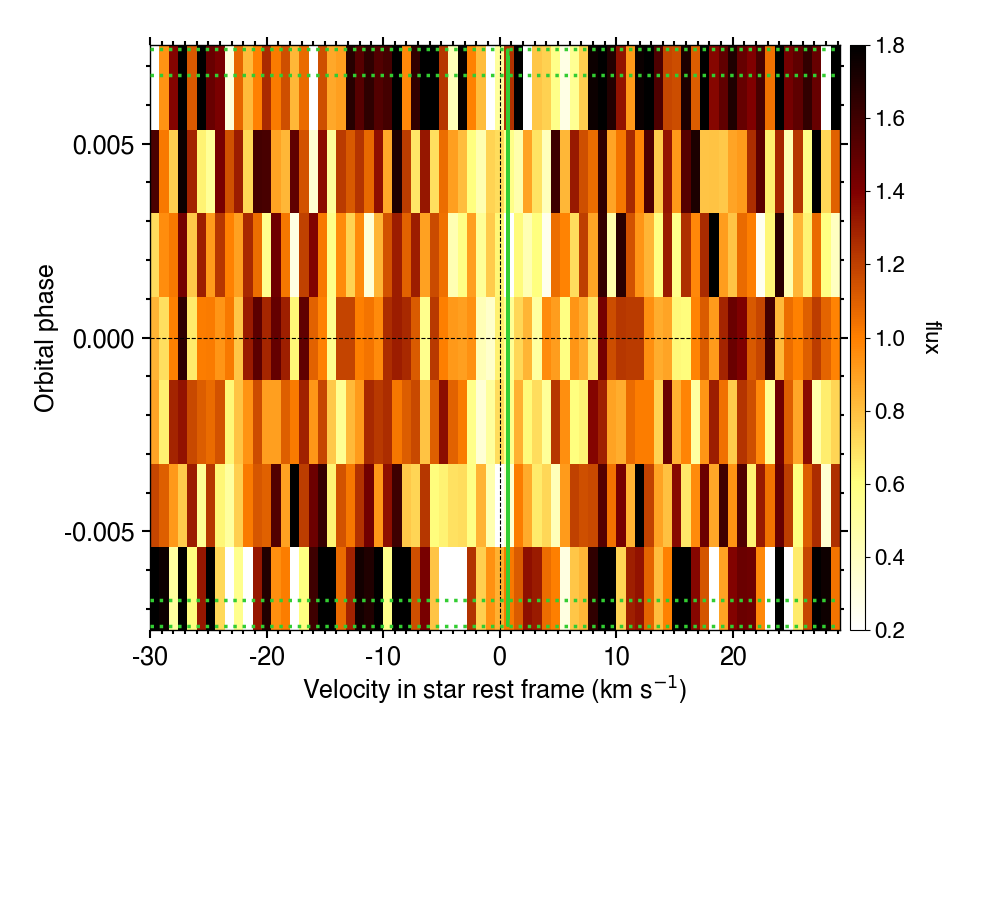

In [18]:
Image(filename = input_nbook['plot_path']+'Intr_data/'+input_nbook['par']['instrument']+'_'+input_nbook['par']['night']+'_Map/Data/CCF/iord0.png', width=800)